# Extract Figueroa 2009 methylation signature probes

In [29]:
library(gdata)
library(dplyr)
library(impute)
library(pheatmap)
library(RColorBrewer)
library(viridis)
library(NbClust)
library(factoextra)
# library(mygene)
# source('helperFunctions.R')

Loading required package: ggplot2
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


## There are 16 clusters of patients defined in Figueroa 2009. Methylation signature of each cluster was provided in [Table S3](https://www.cell.com/cms/attachment/1082556/7973036/mmc3.xls)

In [6]:
n <- 16
clusters <- list()
for (i in seq(n)) {
    clusters[[i]] <- read.xls('../data/mmc3.xls', sheet=i, skip=1, header=T, stringsAsFactor=F)
}

In [7]:
head(clusters[[16]])

HELP_ID,REFSEQ,GENE.SYMBOL,Status
MSPI0406S00055568,NM_016178,OAZ3,Hypermethylated
MSPI0406S00055568,NM_031420,MRPL9,Hypermethylated
MSPI0406S00062872,NM_015569,DNM3,Hypermethylated
MSPI0406S00069595,NM_006618,JARID1B,Hypermethylated
MSPI0406S00083922,NM_014322,OPN3,Hypermethylated
MSPI0406S00099987,NM_173853,KRTCAP3,Hypermethylated


In [8]:
cluster.probes <- list()
for (i in seq(n)) {
    probe.names <- unique(clusters[[i]]$GENE.SYMBOL)
    cluster.probes[[i]] <- probe.names[probe.names!='']
}

In [9]:
sum(unlist(lapply(cluster.probes, length)))

[1] 2719

In [10]:
length(unique(unlist(cluster.probes)))

[1] 944

## Preprocess TCGA LAML HM27 array
- keep probes on autosomes
- remove rows with missingness > 50 %
- impute missing values using KNN

In the end there are 22486 probes left.

In [8]:
in.file <- "/oak/stanford/groups/andrewg/users/szmamie/repos/MethylationPrediction/data/LAML/HM27/LAML.methylation__humanmethylation27__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.data.txt"
data.HM27 <- read.csv(in.file, sep='\t', header=T, stringsAsFactors=F)

In [9]:
head(data.HM27)

Hybridization.REF,TCGA.AB.2802.03A.01D.0741.05,TCGA.AB.2802.03A.01D.0741.05.1,TCGA.AB.2802.03A.01D.0741.05.2,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2803.03A.01D.0741.05.1,TCGA.AB.2803.03A.01D.0741.05.2,TCGA.AB.2803.03A.01D.0741.05.3,TCGA.AB.2804.03A.01D.0741.05,⋯,TCGA.AB.3009.03A.01D.0741.05.2,TCGA.AB.3009.03A.01D.0741.05.3,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3011.03A.01D.0742.05.1,TCGA.AB.3011.03A.01D.0742.05.2,TCGA.AB.3011.03A.01D.0742.05.3,TCGA.AB.3012.03A.01D.0741.05,TCGA.AB.3012.03A.01D.0741.05.1,TCGA.AB.3012.03A.01D.0741.05.2,TCGA.AB.3012.03A.01D.0741.05.3
Composite Element REF,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,⋯,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
cg00000292,0.861564594389913,ATP2A1,16,28890100,0.869796254327262,ATP2A1,16,28890100,0.659263617015686,⋯,16,28890100,0.928697049000533,ATP2A1,16,28890100,0.776383029009759,ATP2A1,16,28890100
cg00002426,0.946342497027903,SLMAP,3,57743543,0.956351509562422,SLMAP,3,57743543,0.952163188492067,⋯,3,57743543,0.943344882215032,SLMAP,3,57743543,0.958471471600558,SLMAP,3,57743543
cg00003994,0.125274641595058,MEOX2,7,15725862,0.0328039420364536,MEOX2,7,15725862,0.0198515878808095,⋯,7,15725862,0.0432628171713411,MEOX2,7,15725862,0.0241999405267976,MEOX2,7,15725862
cg00005847,0.0598080004964315,HOXD3,2,177029073,0.07380597656889,HOXD3,2,177029073,0.0759276258088186,⋯,2,177029073,0.0619550401824966,HOXD3,2,177029073,0.483870393824195,HOXD3,2,177029073
cg00006414,NA,ZNF425;ZNF398,7,148822837,NA,ZNF425;ZNF398,7,148822837,NA,⋯,7,148822837,NA,ZNF425;ZNF398,7,148822837,NA,ZNF425;ZNF398,7,148822837


In [10]:
# remove duplicate columns
num.columns <- dim(data.HM27)[2]
redundant.idx <- c(seq(7, num.columns, by=4), seq(8, num.columns, by=4),
                   seq(9, num.columns, by=4))
data.HM27 <- data.HM27[-1,-redundant.idx] # remove duplicate columns and the subheader

In [11]:
data.HM27[,seq(5)] <- data.HM27[,c(1,3,4,5,2)]
columnnames <- colnames(data.HM27)
columnnames[seq(4)] <- c('ID', 'Gene.Symbol', 'Chromosome', 'Genomic.Coordinate')

In [12]:
colnames(data.HM27) <- columnnames
head(data.HM27)

,ID,Gene.Symbol,Chromosome,Genomic.Coordinate,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
2,cg00000292,ATP2A1,16,28890100,0.861564594389913,0.869796254327262,0.659263617015686,0.932946724632718,0.434150957621834,0.928195228689417,⋯,0.83005568466969,0.822909899344701,0.896799579299195,0.116586283587051,0.803471817822614,0.755601291503743,0.8376730984871,0.874428168920322,0.928697049000533,0.776383029009759
3,cg00002426,SLMAP,3,57743543,0.946342497027903,0.956351509562422,0.952163188492067,0.944987302521737,0.960404867712641,0.910392613236136,⋯,0.954125833073063,0.904435458531103,0.854480226555902,0.907178257587787,0.95398285797124,0.955507212862314,0.943963876160918,0.0914740039517164,0.943344882215032,0.958471471600558
4,cg00003994,MEOX2,7,15725862,0.125274641595058,0.0328039420364536,0.0198515878808095,0.0611239926405519,0.701073431514385,0.323642434664094,⋯,0.0676724573176588,0.0641117583780573,0.164212889387799,0.044640912422344,0.0263884798629089,0.0394962364556658,0.126589731612399,0.780510713213238,0.0432628171713411,0.0241999405267976
5,cg00005847,HOXD3,2,177029073,0.0598080004964315,0.07380597656889,0.0759276258088186,0.418507583461411,0.578411542720016,0.0622155841391899,⋯,0.0987722054558421,0.419468490515621,0.0722420125364288,0.0450166849393871,0.405852511062285,0.0498983050892556,0.413694628901505,0.843740668771244,0.0619550401824966,0.483870393824195
6,cg00006414,ZNF425;ZNF398,7,148822837,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,cg00007981,PANX1,11,93862594,0.0215376632808789,0.0196252163995875,0.0276856671415462,0.0201775775125595,0.0165949846691597,0.0246986033158712,⋯,0.0278169104575322,0.021802428840714,0.0491109694610346,0.0247554209860639,0.0299209972718848,0.0203239370900496,0.0264614106898471,0.0235354854469433,0.0307930650695307,0.0218305446674515


In [13]:
dim(data.HM27) # original data size

[1] 27578   198

In [14]:
print(unique(data.HM27$Chromosome))

 [1] "16" "3"  "7"  "2"  "11" "14" "18" NA   "1"  "6"  "22" "12" "4"  "17" "20"
[16] "10" "X"  "19" "9"  "13" "8"  "5"  "15" "21" "Y" 


In [15]:
# remove X, Y, NA chromosome 
data.HM27 <- data.HM27 %>%
  dplyr::filter(!(Chromosome %in% c("X", "Y", NA)))

In [16]:
dim(data.HM27) # keep only autosomal probes

[1] 25014   198

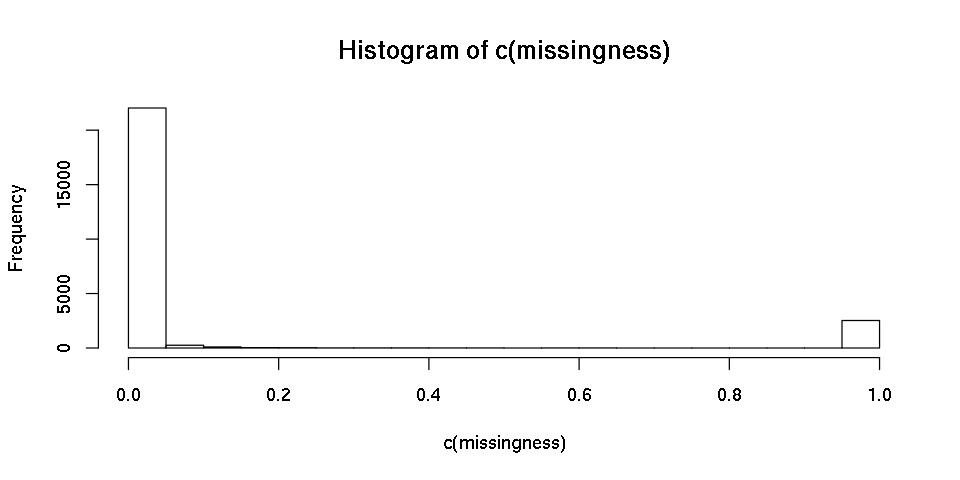

In [17]:
# remove rows with missingness > 10 % and impute missing beta values 
options(repr.plot.width=8, repr.plot.height=4)
missingness <- apply(data.HM27[,-seq(4)], 1, function(x) mean(is.na(x)))
hist(c(missingness), breaks=30)

In [18]:
sum(missingness >= 0.5) # 2528 rows to remove with > 0.5 missingness

[1] 2528

In [19]:
data.HM27 <- data.HM27[missingness < 0.5,]
dim(data.HM27) # remove missing probes

[1] 22486   198

In [20]:
head(data.HM27)

,ID,Gene.Symbol,Chromosome,Genomic.Coordinate,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
1,cg00000292,ATP2A1,16,28890100,0.861564594389913,0.869796254327262,0.659263617015686,0.932946724632718,0.434150957621834,0.928195228689417,⋯,0.83005568466969,0.822909899344701,0.896799579299195,0.116586283587051,0.803471817822614,0.755601291503743,0.8376730984871,0.874428168920322,0.928697049000533,0.776383029009759
2,cg00002426,SLMAP,3,57743543,0.946342497027903,0.956351509562422,0.952163188492067,0.944987302521737,0.960404867712641,0.910392613236136,⋯,0.954125833073063,0.904435458531103,0.854480226555902,0.907178257587787,0.95398285797124,0.955507212862314,0.943963876160918,0.0914740039517164,0.943344882215032,0.958471471600558
3,cg00003994,MEOX2,7,15725862,0.125274641595058,0.0328039420364536,0.0198515878808095,0.0611239926405519,0.701073431514385,0.323642434664094,⋯,0.0676724573176588,0.0641117583780573,0.164212889387799,0.044640912422344,0.0263884798629089,0.0394962364556658,0.126589731612399,0.780510713213238,0.0432628171713411,0.0241999405267976
4,cg00005847,HOXD3,2,177029073,0.0598080004964315,0.07380597656889,0.0759276258088186,0.418507583461411,0.578411542720016,0.0622155841391899,⋯,0.0987722054558421,0.419468490515621,0.0722420125364288,0.0450166849393871,0.405852511062285,0.0498983050892556,0.413694628901505,0.843740668771244,0.0619550401824966,0.483870393824195
6,cg00007981,PANX1,11,93862594,0.0215376632808789,0.0196252163995875,0.0276856671415462,0.0201775775125595,0.0165949846691597,0.0246986033158712,⋯,0.0278169104575322,0.021802428840714,0.0491109694610346,0.0247554209860639,0.0299209972718848,0.0203239370900496,0.0264614106898471,0.0235354854469433,0.0307930650695307,0.0218305446674515
7,cg00008493,COX8C;KIAA1409,14,93813777,0.981396555005453,0.981749684415936,0.98403200299398,0.986814081141049,0.985375369737061,0.981171686729287,⋯,0.986511791525834,0.975793228408668,0.981439717909794,0.983013757322295,0.985596206515573,0.985931551668339,0.985511914327982,0.98634041766771,0.984950726081008,0.984399675867947


In [21]:
data.HM27.imputed <- impute.knn(data.matrix(data.HM27[,-seq(4)]), k = 10, rowmax = 0.5, colmax = 0.8, maxp = 1500, rng.seed=362436069) # impute using KNN

Cluster size 22486 broken into 16374 6112 
Cluster size 16374 broken into 2768 13606 
Cluster size 2768 broken into 1057 1711 
Done cluster 1057 
Cluster size 1711 broken into 685 1026 
Done cluster 685 
Done cluster 1026 
Done cluster 1711 
Done cluster 2768 
Cluster size 13606 broken into 11025 2581 
Cluster size 11025 broken into 2683 8342 
Cluster size 2683 broken into 353 2330 
Done cluster 353 
Cluster size 2330 broken into 647 1683 
Done cluster 647 
Cluster size 1683 broken into 373 1310 
Done cluster 373 
Done cluster 1310 
Done cluster 1683 
Done cluster 2330 
Done cluster 2683 
Cluster size 8342 broken into 5354 2988 
Cluster size 5354 broken into 2694 2660 
Cluster size 2694 broken into 89 2605 
Done cluster 89 
Cluster size 2605 broken into 2599 6 
Cluster size 2599 broken into 2272 327 
Cluster size 2272 broken into 1365 907 
Done cluster 1365 
Done cluster 907 
Done cluster 2272 
Done cluster 327 
Done cluster 2599 
Done cluster 6 
Done cluster 2605 
Done cluster 2694 
C

In [22]:
head(data.HM27.imputed$data)

,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
1,0.86156459,0.86979625,0.65926362,0.93294672,0.43415096,0.92819523,0.78032215,0.59317697,0.94480293,0.58047182,⋯,0.83005568,0.82290990,0.89679958,0.11658628,0.80347182,0.75560129,0.83767310,0.87442817,0.92869705,0.77638303
2,0.94634250,0.95635151,0.95216319,0.94498730,0.96040487,0.91039261,0.92129838,0.91930527,0.95642581,0.93849838,⋯,0.95412583,0.90443546,0.85448023,0.90717826,0.95398286,0.95550721,0.94396388,0.09147400,0.94334488,0.95847147
3,0.12527464,0.03280394,0.01985159,0.06112399,0.70107343,0.32364243,0.04443957,0.02832298,0.02952006,0.01792710,⋯,0.06767246,0.06411176,0.16421289,0.04464091,0.02638848,0.03949624,0.12658973,0.78051071,0.04326282,0.02419994
4,0.05980800,0.07380598,0.07592763,0.41850758,0.57841154,0.06221558,0.07963455,0.04705453,0.04435912,0.03485283,⋯,0.09877221,0.41946849,0.07224201,0.04501668,0.40585251,0.04989831,0.41369463,0.84374067,0.06195504,0.48387039
6,0.02153766,0.01962522,0.02768567,0.02017758,0.01659498,0.02469860,0.03145926,0.02087033,0.02540435,0.02989397,⋯,0.02781691,0.02180243,0.04911097,0.02475542,0.02992100,0.02032394,0.02646141,0.02353549,0.03079307,0.02183054
7,0.98139656,0.98174968,0.98403200,0.98681408,0.98537537,0.98117169,0.97975446,0.98762202,0.98431479,0.98766407,⋯,0.98651179,0.97579323,0.98143972,0.98301376,0.98559621,0.98593155,0.98551191,0.98634042,0.98495073,0.98439968


In [23]:
HM27.processed <- data.HM27.imputed$data
rownames(HM27.processed) <- c(data.HM27$Gene.Symbol)

In [24]:
head(HM27.processed)

,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
ATP2A1,0.86156459,0.86979625,0.65926362,0.93294672,0.43415096,0.92819523,0.78032215,0.59317697,0.94480293,0.58047182,⋯,0.83005568,0.82290990,0.89679958,0.11658628,0.80347182,0.75560129,0.83767310,0.87442817,0.92869705,0.77638303
SLMAP,0.94634250,0.95635151,0.95216319,0.94498730,0.96040487,0.91039261,0.92129838,0.91930527,0.95642581,0.93849838,⋯,0.95412583,0.90443546,0.85448023,0.90717826,0.95398286,0.95550721,0.94396388,0.09147400,0.94334488,0.95847147
MEOX2,0.12527464,0.03280394,0.01985159,0.06112399,0.70107343,0.32364243,0.04443957,0.02832298,0.02952006,0.01792710,⋯,0.06767246,0.06411176,0.16421289,0.04464091,0.02638848,0.03949624,0.12658973,0.78051071,0.04326282,0.02419994
HOXD3,0.05980800,0.07380598,0.07592763,0.41850758,0.57841154,0.06221558,0.07963455,0.04705453,0.04435912,0.03485283,⋯,0.09877221,0.41946849,0.07224201,0.04501668,0.40585251,0.04989831,0.41369463,0.84374067,0.06195504,0.48387039
PANX1,0.02153766,0.01962522,0.02768567,0.02017758,0.01659498,0.02469860,0.03145926,0.02087033,0.02540435,0.02989397,⋯,0.02781691,0.02180243,0.04911097,0.02475542,0.02992100,0.02032394,0.02646141,0.02353549,0.03079307,0.02183054
COX8C;KIAA1409,0.98139656,0.98174968,0.98403200,0.98681408,0.98537537,0.98117169,0.97975446,0.98762202,0.98431479,0.98766407,⋯,0.98651179,0.97579323,0.98143972,0.98301376,0.98559621,0.98593155,0.98551191,0.98634042,0.98495073,0.98439968


In [25]:
dim(HM27.processed)

[1] 22486   194

In [28]:
sum(duplicated(rownames(HM27.processed))) # number of unique genes in the filtered array are 9328

[1] 9328

In [27]:
write.table(HM27.processed, file='../data/LAML/processed/HM27-imputed.tsv', sep='\t', row.names=T, col.names=T, quote=F)

# preprocess with RNAseq 
- combine with RNAseq for the subset of patients (and specific type of sample)

In [100]:
in.file <- '/oak/stanford/groups/andrewg/users/szmamie/repos/MethylationPrediction/data/LAML/mRNAseq/LAML.uncv2.mRNAseq_RSEM_normalized_log2.txt'
rnaseq <- read.csv(in.file, sep='\t', header=T, stringsAsFactors=F)

In [101]:
dim(rnaseq)
head(rnaseq)

[1] 17276   174

gene,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
?|100133144,NA,0.4208327,3.826640,3.221057,5.402640,0.647821,NA,3.840856,1.8047970,⋯,3.216765,4.7766041,3.9145932,2.15458321,2.652693,1.844787,4.697946,5.505986,4.764224,4.366889
?|100134869,NA,NA,4.032577,3.756532,4.827692,3.164545,2.7981750,3.578528,0.4660267,⋯,1.124857,4.0356239,2.8328900,3.48600637,3.917050,3.537048,4.794405,5.802783,4.010305,3.579578
?|10357,6.532825,6.5334154,6.902062,7.479142,7.411123,7.248636,4.9217362,6.911201,5.6777422,⋯,6.913258,6.5966519,7.1146814,6.59370932,6.537691,6.287325,7.352016,6.743757,6.353013,6.433525
?|10431,9.775681,8.7200277,9.287896,9.069421,9.352207,10.086886,10.4662398,9.910729,9.2161621,⋯,8.876121,9.3516754,9.1684405,9.65172641,9.521703,10.133399,9.381312,8.999307,9.599865,10.110110
?|155060,9.293637,9.2927252,9.690391,9.360624,9.123443,9.782750,9.4943382,8.374807,7.8297456,⋯,10.749588,8.9519785,9.6788927,9.18547783,9.331199,10.038919,10.461403,11.256595,9.306328,9.182408
?|26823,3.210903,3.2281722,2.155684,2.311852,1.236707,1.396872,0.6826632,1.808756,2.2854318,⋯,1.520749,0.9296395,0.9492735,-0.03120881,1.611833,1.678072,NA,0.854634,NA,-0.102992


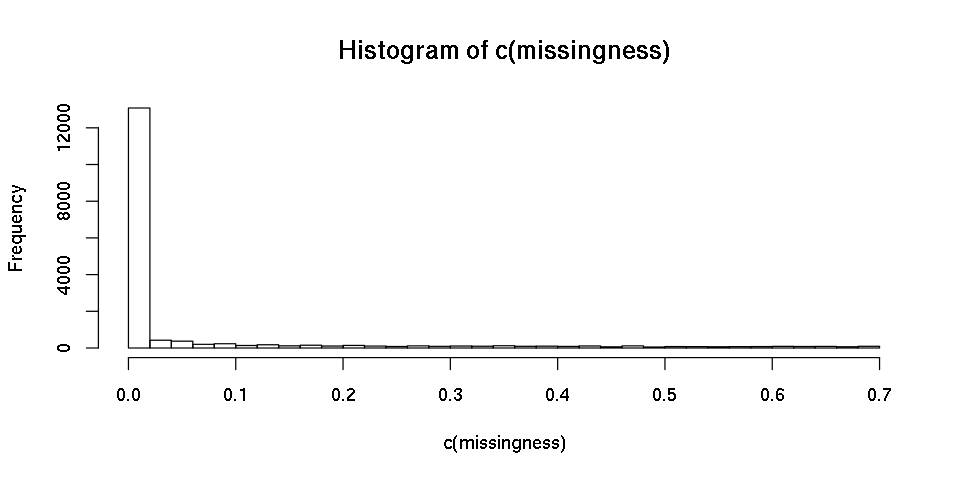

In [102]:
# remove rows with missingness > 10 % and impute missing beta values 
options(repr.plot.width=8, repr.plot.height=4)
missingness <- apply(rnaseq[,-1], 1, function(x) mean(is.na(x)))
hist(c(missingness), breaks=30)

In [103]:
# remove missingness is greater than 50 %
rnaseq <- rnaseq[missingness < 0.5,]
dim(rnaseq) # remove missing probes

[1] 16485   174

In [104]:
rnaseq.imputed <- impute.knn(data.matrix(rnaseq[,-1]), k = 10, rowmax = 0.5, colmax = 0.8, maxp = 1500, rng.seed=362436069) # impute using KNN

Cluster size 16485 broken into 5726 10759 
Cluster size 5726 broken into 2935 2791 
Cluster size 2935 broken into 1215 1720 
Done cluster 1215 
Cluster size 1720 broken into 954 766 
Done cluster 954 
Done cluster 766 
Done cluster 1720 
Done cluster 2935 
Cluster size 2791 broken into 1435 1356 
Done cluster 1435 
Done cluster 1356 
Done cluster 2791 
Done cluster 5726 
Cluster size 10759 broken into 5433 5326 
Cluster size 5433 broken into 3459 1974 
Cluster size 3459 broken into 194 3265 
Done cluster 194 
Cluster size 3265 broken into 1589 1676 
Cluster size 1589 broken into 2 1587 
Done cluster 2 
Cluster size 1587 broken into 644 943 
Done cluster 644 
Done cluster 943 
Done cluster 1587 
Done cluster 1589 
Cluster size 1676 broken into 1008 668 
Done cluster 1008 
Done cluster 668 
Done cluster 1676 
Done cluster 3265 
Done cluster 3459 
Cluster size 1974 broken into 1544 430 
Cluster size 1544 broken into 919 625 
Done cluster 919 
Done cluster 625 
Done cluster 1544 
Done clus

In [107]:
rownames(rnaseq.imputed$data) <- rnaseq[,1]

In [108]:
dim(rnaseq.imputed$data)
head(rnaseq.imputed$data)

[1] 16485   173

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
?|100133144,2.462513,0.4208327,3.826640,3.221057,5.402640,0.647821,2.1394848,3.840856,1.8047970,5.829492,⋯,3.216765,4.7766041,3.9145932,2.15458321,2.652693,1.844787,4.697946,5.505986,4.764224,4.366889
?|100134869,2.972494,2.3595729,4.032577,3.756532,4.827692,3.164545,2.7981750,3.578528,0.4660267,6.891238,⋯,1.124857,4.0356239,2.8328900,3.48600637,3.917050,3.537048,4.794405,5.802783,4.010305,3.579578
?|10357,6.532825,6.5334154,6.902062,7.479142,7.411123,7.248636,4.9217362,6.911201,5.6777422,6.445953,⋯,6.913258,6.5966519,7.1146814,6.59370932,6.537691,6.287325,7.352016,6.743757,6.353013,6.433525
?|10431,9.775681,8.7200277,9.287896,9.069421,9.352207,10.086886,10.4662398,9.910729,9.2161621,8.884754,⋯,8.876121,9.3516754,9.1684405,9.65172641,9.521703,10.133399,9.381312,8.999307,9.599865,10.110110
?|155060,9.293637,9.2927252,9.690391,9.360624,9.123443,9.782750,9.4943382,8.374807,7.8297456,9.029952,⋯,10.749588,8.9519785,9.6788927,9.18547783,9.331199,10.038919,10.461403,11.256595,9.306328,9.182408
?|26823,3.210903,3.2281722,2.155684,2.311852,1.236707,1.396872,0.6826632,1.808756,2.2854318,2.475370,⋯,1.520749,0.9296395,0.9492735,-0.03120881,1.611833,1.678072,1.125440,0.854634,2.095495,-0.102992


In [116]:
# change the rownames to be the gene symbol
rownames(rnaseq.imputed$data) <- as.character(sapply(rownames(rnaseq.imputed$data), function(x) strsplit(x, '|', fixed=T)[[1]][1]))

In [117]:
write.table(rnaseq.imputed$data, file='../data/LAML/processed/RNAseq-imputed.tsv', sep='\t', quote=F, col.names=T, row.names=T)

# Subset for patients with specific sample code and matching with RNAseq

In [118]:
sample.code <- '03'
HM27.unmatched <- read.csv('../data/LAML/processed/HM27-imputed.tsv', sep='\t', stringsAsFactor=F, header=F)

In [119]:
head(HM27.unmatched)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195
TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05,NA
ATP2A1,0.861564594389913,0.869796254327262,0.659263617015686,0.932946724632718,0.434150957621834,0.928195228689417,0.780322146643444,0.593176971784206,0.944802929713935,⋯,0.83005568466969,0.822909899344701,0.896799579299195,0.116586283587051,0.803471817822614,0.755601291503743,0.8376730984871,0.874428168920322,0.928697049000533,0.77638303
SLMAP,0.946342497027903,0.956351509562422,0.952163188492067,0.944987302521737,0.960404867712641,0.910392613236136,0.921298377524728,0.91930527217743,0.956425814692814,⋯,0.954125833073063,0.904435458531103,0.854480226555902,0.907178257587787,0.95398285797124,0.955507212862314,0.943963876160918,0.0914740039517164,0.943344882215032,0.95847147
MEOX2,0.125274641595058,0.0328039420364536,0.0198515878808095,0.0611239926405519,0.701073431514385,0.323642434664094,0.0444395655705638,0.0283229785783342,0.0295200623089477,⋯,0.0676724573176588,0.0641117583780573,0.164212889387799,0.044640912422344,0.0263884798629089,0.0394962364556658,0.126589731612399,0.780510713213238,0.0432628171713411,0.02419994
HOXD3,0.0598080004964315,0.07380597656889,0.0759276258088186,0.418507583461411,0.578411542720016,0.0622155841391899,0.0796345494499635,0.0470545314329183,0.0443591175794742,⋯,0.0987722054558421,0.419468490515621,0.0722420125364288,0.0450166849393871,0.405852511062285,0.0498983050892556,0.413694628901505,0.843740668771244,0.0619550401824966,0.48387039
PANX1,0.0215376632808789,0.0196252163995875,0.0276856671415462,0.0201775775125595,0.0165949846691597,0.0246986033158712,0.0314592601209679,0.0208703314610387,0.0254043501991569,⋯,0.0278169104575322,0.021802428840714,0.0491109694610346,0.0247554209860639,0.0299209972718848,0.0203239370900496,0.0264614106898471,0.0235354854469433,0.0307930650695307,0.02183054


In [121]:
patients.rnaseq <- colnames(rnaseq.imputed$data)
tumor.sample <- sapply(patients.rnaseq, function(x) {
                                 samplecode = substr(x, 14, 15)
                                 return(samplecode == sample.code)
                                 })
rnaseq.filtered <- rnaseq.imputed$data[, tumor.sample]
dim(rnaseq.filtered)
head(rnaseq.filtered)

[1] 16485   173

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
?,2.462513,0.4208327,3.826640,3.221057,5.402640,0.647821,2.1394848,3.840856,1.8047970,5.829492,⋯,3.216765,4.7766041,3.9145932,2.15458321,2.652693,1.844787,4.697946,5.505986,4.764224,4.366889
?,2.972494,2.3595729,4.032577,3.756532,4.827692,3.164545,2.7981750,3.578528,0.4660267,6.891238,⋯,1.124857,4.0356239,2.8328900,3.48600637,3.917050,3.537048,4.794405,5.802783,4.010305,3.579578
?,6.532825,6.5334154,6.902062,7.479142,7.411123,7.248636,4.9217362,6.911201,5.6777422,6.445953,⋯,6.913258,6.5966519,7.1146814,6.59370932,6.537691,6.287325,7.352016,6.743757,6.353013,6.433525
?,9.775681,8.7200277,9.287896,9.069421,9.352207,10.086886,10.4662398,9.910729,9.2161621,8.884754,⋯,8.876121,9.3516754,9.1684405,9.65172641,9.521703,10.133399,9.381312,8.999307,9.599865,10.110110
?,9.293637,9.2927252,9.690391,9.360624,9.123443,9.782750,9.4943382,8.374807,7.8297456,9.029952,⋯,10.749588,8.9519785,9.6788927,9.18547783,9.331199,10.038919,10.461403,11.256595,9.306328,9.182408
?,3.210903,3.2281722,2.155684,2.311852,1.236707,1.396872,0.6826632,1.808756,2.2854318,2.475370,⋯,1.520749,0.9296395,0.9492735,-0.03120881,1.611833,1.678072,1.125440,0.854634,2.095495,-0.102992


In [127]:
# convert colnames of HM27 to the same format as the RNAseq
m <- dim(HM27.unmatched)[2]
patients.hm27 <- HM27.unmatched[1,-m]
patients.hm27 <- sapply(patients.hm27, function(x) toupper(substr(x, 1, 15)))

In [130]:
sum(duplicated(patients.hm27)) # no duplicate samples for each patients
patients.matched <- which(patients.hm27 %in% colnames(rnaseq.filtered))
length(patients.matched)

[1] 0

[1] 170

In [136]:
hm27.filtered <- data.matrix(HM27.unmatched[-1, -1][,patients.matched])
colnames(hm27.filtered) <- patients.hm27[patients.matched]
rownames(hm27.filtered) <- HM27.unmatched[-1,1]
dim(hm27.filtered)
head(hm27.filtered)

[1] 22486   170

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
ATP2A1,0.86979625,0.93294672,0.43415096,0.92819523,0.78032215,0.94480293,0.58047182,0.78701084,0.75055969,0.83858902,⋯,0.83005568,0.82290990,0.89679958,0.11658628,0.80347182,0.75560129,0.83767310,0.87442817,0.92869705,0.77638303
SLMAP,0.95635151,0.94498730,0.96040487,0.91039261,0.92129838,0.95642581,0.93849838,0.95391667,0.93345208,0.95348309,⋯,0.95412583,0.90443546,0.85448023,0.90717826,0.95398286,0.95550721,0.94396388,0.09147400,0.94334488,0.95847147
MEOX2,0.03280394,0.06112399,0.70107343,0.32364243,0.04443957,0.02952006,0.01792710,0.02763332,0.02973350,0.04404321,⋯,0.06767246,0.06411176,0.16421289,0.04464091,0.02638848,0.03949624,0.12658973,0.78051071,0.04326282,0.02419994
HOXD3,0.07380598,0.41850758,0.57841154,0.06221558,0.07963455,0.04435912,0.03485283,0.49713598,0.39456513,0.36528964,⋯,0.09877221,0.41946849,0.07224201,0.04501668,0.40585251,0.04989831,0.41369463,0.84374067,0.06195504,0.48387039
PANX1,0.01962522,0.02017758,0.01659498,0.02469860,0.03145926,0.02540435,0.02989397,0.02599819,0.02330787,0.03252096,⋯,0.02781691,0.02180243,0.04911097,0.02475542,0.02992100,0.02032394,0.02646141,0.02353549,0.03079307,0.02183054
COX8C;KIAA1409,0.98174968,0.98681408,0.98537537,0.98117169,0.97975446,0.98431479,0.98766407,0.98945402,0.98630701,0.98739797,⋯,0.98651179,0.97579323,0.98143972,0.98301376,0.98559621,0.98593155,0.98551191,0.98634042,0.98495073,0.98439968


In [140]:
arrangeIdx <- function(x) {
    which(colnames(rnaseq.filtered) %in% x)
}
ArrangeIdx <- Vectorize(arrangeIdx)

In [143]:
rnaseq.filtered <- rnaseq.filtered[,ArrangeIdx(as.character(colnames(hm27.filtered)))]

In [144]:
dim(rnaseq.filtered)

[1] 16485   170

In [146]:
write.table(rnaseq.filtered, file='../data/LAML/processed/rnaseq-imputed-matched.tsv', sep='\t', quote=F, col.names=T, row.names=T)

In [147]:
write.table(hm27.filtered, file='../data/LAML/processed/hm27-imputed-matched.tsv', sep='\t', quote=F, col.names=T, row.names=T)

# Find corresponding probes in the Figueroa paper

In [ ]:
findIdx <- function(probe.name) which(grepl(paste0(probe.name, '$|', probe.name, ';'), rownames(hm27.filtered), fixed=F))
FindIdx <- Vectorize(findIdx)                              
res <- FindIdx(cluster.probes[[1]])

### there are more than one probes matching each gene in the cluster

In [149]:
print(str(res)) # Figueroa cluster 1 genes in HM27

List of 173
 $ PHF13        : int [1:2] 5491 6987
 $ HNRPR        : int(0) 
 $ HNRNPR       : int [1:2] 1464 5200
 $ TIE1         : int(0) 
 $ SYDE2        : int(0) 
 $ THEM4        : int [1:2] 3220 5677
 $ FCRLB        : int [1:2] 21193 22354
 $ DNM3         : int [1:2] 826 19061
 $ ZNF281       : int [1:2] 7474 14637
 $ MRPL55       : int [1:2] 6687 7642
 $ LBX2         : int(0) 
 $ SDPR         : int [1:2] 5121 11747
 $ ICA1L        : int [1:3] 8842 11679 21634
 $ ZNF662       : int 21602
 $ CISH         : int [1:2] 5755 7252
 $ FSTL1        : int [1:2] 16396 18321
 $ TXNRD3       : int(0) 
 $ PFN2         : int [1:2] 2371 19762
 $ GPR149       : int(0) 
 $ PIGZ         : int [1:2] 775 4809
 $ CCDC96       : int [1:2] 3082 7604
 $ MGC21874     : int(0) 
 $ CXCL1        : int [1:2] 1662 21017
 $ EREG         : int [1:2] 4038 15747
 $ TLR2         : int [1:2] 5364 15529
 $ DKFZP686E2158: int(0) 
 $ CRHBP        : int [1:2] 13535 17815
 $ NEUROG1      : int [1:5] 3535 4012 9095 9669 12

# Convert to M value to have better statistical behavior

\begin{align}
\beta &= \frac{2^M}{2^M + 1} \\
M &= \log_2 \frac{\beta}{1 - \beta}
\end{align}

In [150]:
beta2M <- function(beta) {
    log(beta/(1 - beta), base=2)
}
Beta2M <- Vectorize(beta2M)

In [152]:
HM27.processed <- apply(hm27.filtered, 2, Beta2M)

In [153]:
write.table(HM27.processed, file='../data/LAML/processed/hm27-imputed-matched-Mvalue.tsv', sep='\t', row.names=T, col.names=T, quote=F)

In [154]:
head(HM27.processed)

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
ATP2A1,2.739907,3.7984150,-0.3822205,3.692277,1.828680,4.097350,0.4684583,1.88560348,1.5892722,2.3772252,⋯,2.288146,2.2162509,3.119337,-2.921691,2.0315112,1.628389,2.367485,2.799827,3.703174,1.79573890
SLMAP,4.453537,4.1024584,4.6002477,3.344799,3.549203,4.456107,3.9316580,4.37154650,3.8101104,4.3573803,⋯,4.378426,3.2424702,2.553832,3.288851,4.3737201,4.424623,4.074303,-3.312094,4.057507,4.52856084
MEOX2,-4.881867,-3.9411240,1.2297744,-1.063385,-4.426431,-5.038931,-5.7756161,-5.13701986,-5.0282200,-4.4399539,⋯,-3.784196,-3.8676754,-2.347568,-4.419605,-5.2053661,-4.604004,-2.786499,1.830268,-4.466923,-5.33351016
HOXD3,-3.649505,-0.4745066,0.4562610,-3.913908,-3.530740,-4.429166,-4.7914013,-0.01652784,-0.6177083,-0.7970576,⋯,-3.189715,-0.4688119,-3.682839,-4.406944,-0.5498656,-4.251019,-0.503086,2.432857,-3.920364,-0.09311272
PANX1,-5.642553,-5.6016954,-5.8889665,-5.303347,-4.944256,-5.261656,-5.0202161,-5.22744163,-5.3890148,-4.8947886,⋯,-5.127194,-5.4875651,-4.275160,-5.299948,-5.0188721,-5.591053,-5.201276,-5.374658,-4.976127,-5.48566438
COX8C;KIAA1409,5.749362,6.2257083,6.0742014,5.703530,5.596744,5.971643,6.3230816,6.55186699,6.1705269,6.2919037,⋯,6.192566,5.3330929,5.724609,5.854773,6.0964760,6.130952,6.087934,6.174100,6.032286,5.97959627


In [155]:
PlotHeatmap <- function(i) {
    idx <- FindIdx(cluster.probes[[i]])
    options(repr.plot.width=6, repr.plot.height=6)
    pheatmap(
      mat               = HM27.processed[unlist(idx),],
      color             = inferno(20),
      border_color      = NA,
      show_colnames     = FALSE,
      show_rownames     = FALSE,
      fontsize          = 14,
      main              = paste0("cluster ", i)
    )
}

## Figueroa cluster 1 in TCGA

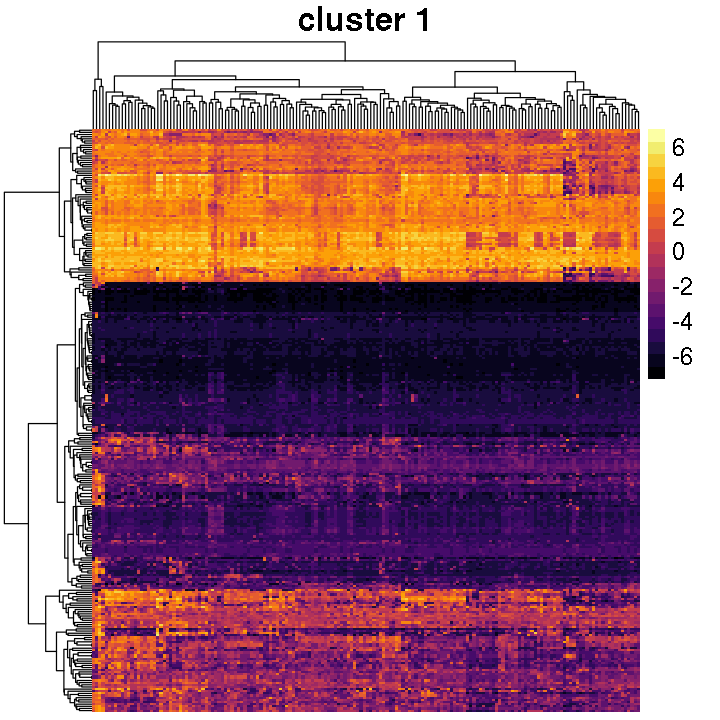

In [156]:
PlotHeatmap(1)

## patients are columns and probes are rows. It doesn't quite looks like a single cluster of probes. The same observation for the rest of the clusters:

## cluster 2

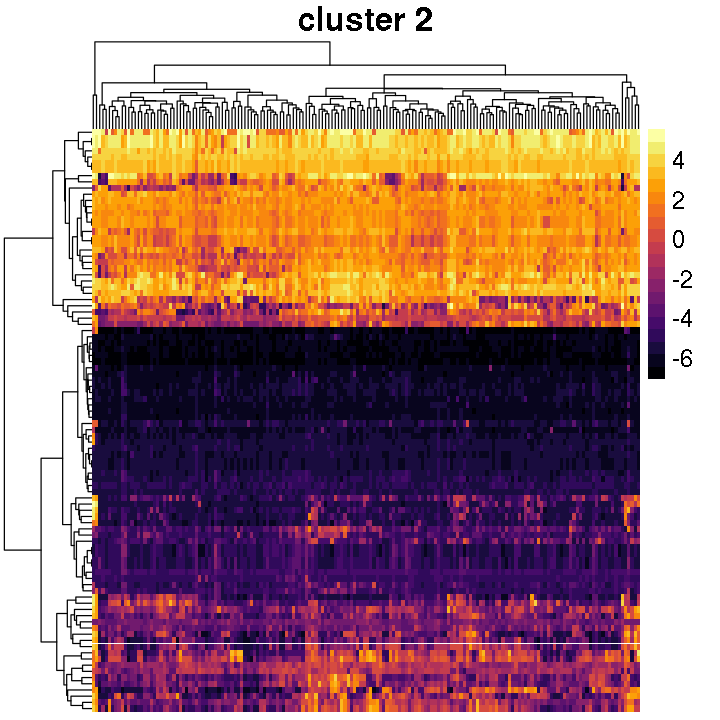

In [157]:
PlotHeatmap(2)

## cluster 3

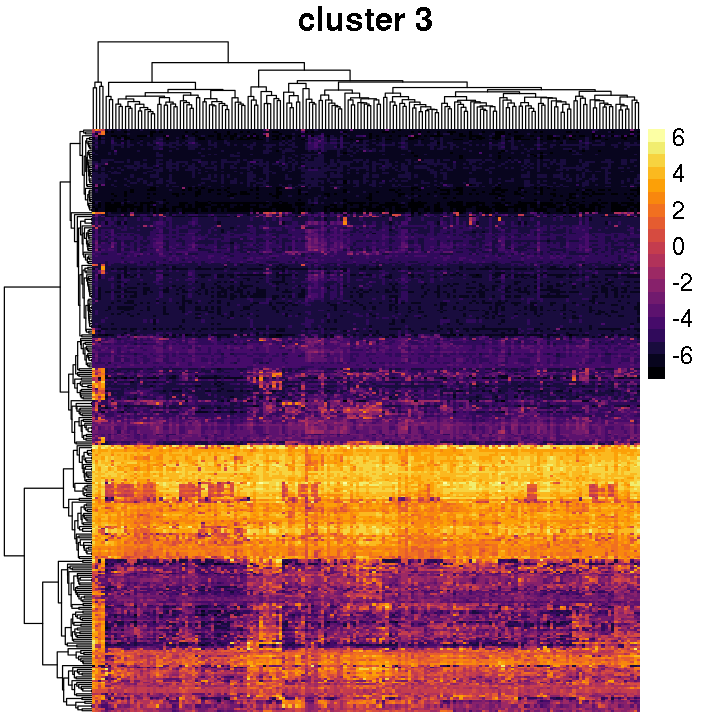

In [158]:
PlotHeatmap(3)

# Clustering on all probes from Figueroa clusters and 7 clusters on probes end up with a reasonable number of probes in each cluster

In [1]:
HM27.processed.raw <- read.csv('../data/LAML/processed/hm27-imputed-matched-Mvalue.tsv', sep='\t', stringsAsFactor=F, header=F)
HM27.processed <- data.matrix(HM27.processed.raw[-1,-1])

rownames(HM27.processed) <- HM27.processed.raw[-1,1]
colnames(HM27.processed) <- HM27.processed.raw[1,-dim(HM27.processed.raw)[2]]
head(HM27.processed)

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
ATP2A1,2.739907,3.7984150,-0.3822205,3.692277,1.828680,4.097350,0.4684583,1.88560348,1.5892722,2.3772252,⋯,2.288146,2.2162509,3.119337,-2.921691,2.0315112,1.628389,2.367485,2.799827,3.703174,1.79573890
SLMAP,4.453537,4.1024584,4.6002477,3.344799,3.549203,4.456107,3.9316580,4.37154650,3.8101104,4.3573803,⋯,4.378426,3.2424702,2.553832,3.288851,4.3737201,4.424623,4.074303,-3.312094,4.057507,4.52856084
MEOX2,-4.881867,-3.9411240,1.2297744,-1.063385,-4.426431,-5.038931,-5.7756161,-5.13701986,-5.0282200,-4.4399539,⋯,-3.784196,-3.8676754,-2.347568,-4.419605,-5.2053661,-4.604004,-2.786499,1.830268,-4.466923,-5.33351016
HOXD3,-3.649505,-0.4745066,0.4562610,-3.913908,-3.530740,-4.429166,-4.7914013,-0.01652784,-0.6177083,-0.7970576,⋯,-3.189715,-0.4688119,-3.682839,-4.406944,-0.5498656,-4.251019,-0.503086,2.432857,-3.920364,-0.09311272
PANX1,-5.642553,-5.6016954,-5.8889665,-5.303347,-4.944256,-5.261656,-5.0202161,-5.22744163,-5.3890148,-4.8947886,⋯,-5.127194,-5.4875651,-4.275160,-5.299948,-5.0188721,-5.591053,-5.201276,-5.374658,-4.976127,-5.48566438
COX8C;KIAA1409,5.749362,6.2257083,6.0742014,5.703530,5.596744,5.971643,6.3230816,6.55186699,6.1705269,6.2919037,⋯,6.192566,5.3330929,5.724609,5.854773,6.0964760,6.130952,6.087934,6.174100,6.032286,5.97959627


In [13]:
cluster.probes.all <- unique(unlist(cluster.probes))

findIdx <- function(probe.name) which(grepl(paste0(probe.name, '$|', probe.name, ';'), rownames(HM27.processed), fixed=F))
FindIdx <- Vectorize(findIdx)       

idx <- FindIdx(cluster.probes.all)

In [14]:
probe.idx <- c(unlist(idx))
length(probe.idx)

[1] 1470

## Decide optimal number of clusters

Warning message in max(DiffLev[, 3], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(DiffLev[, 4], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 


Warning message in matrix(c(results), nrow = 2, ncol = 26):
“data length [50] is not a sub-multiple or multiple of the number of columns [26]”Warning message in matrix(c(results), nrow = 2, ncol = 26, dimnames = list(c("Number_clusters", :
“data length [50] is not a sub-multiple or multiple of the number of columns [26]”

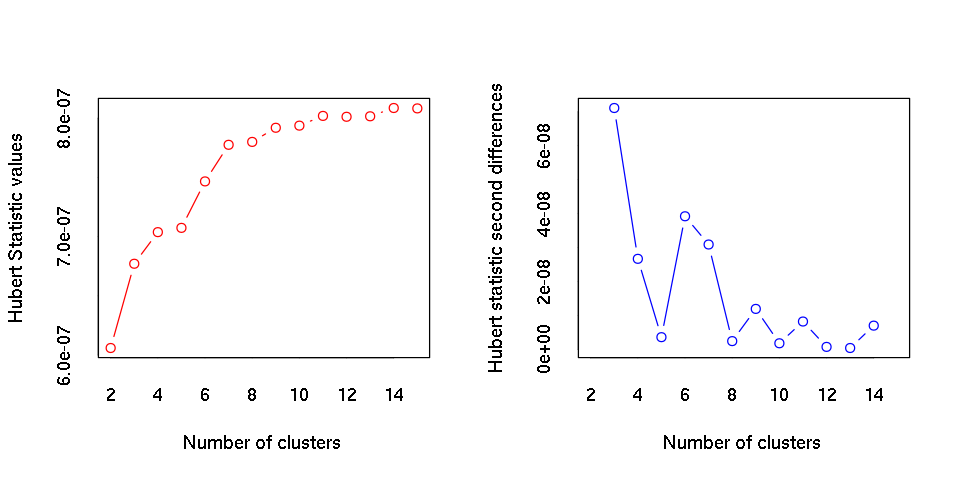

******************************************************************* 
* Among all indices:                                                
* 8 proposed 2 as the best number of clusters 
* 6 proposed 3 as the best number of clusters 
* 5 proposed 4 as the best number of clusters 
* 1 proposed 11 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


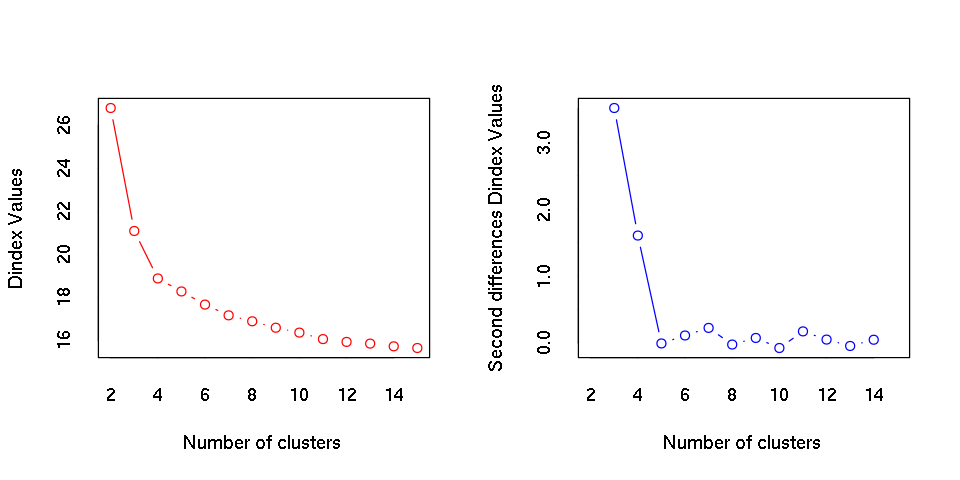

In [57]:
options(repr.plot.width=8, repr.plot.height=4)
nb <- NbClust(data = HM27.processed[probe.idx,][sd.probes > 0.5,], diss = NULL, distance = "euclidean", min.nc = 2, max.nc = 15, method = "ward.D2", index = "all", alphaBeale = 0.1)

Among all indices: 
* 1 proposed  -Inf as the best number of clusters
* 2 proposed  0 as the best number of clusters
* 8 proposed  2 as the best number of clusters
* 6 proposed  3 as the best number of clusters
* 5 proposed  4 as the best number of clusters
* 1 proposed  11 as the best number of clusters
* 3 proposed  NA's as the best number of clusters

Conclusion
* According to the majority rule, the best number of clusters is  2 .



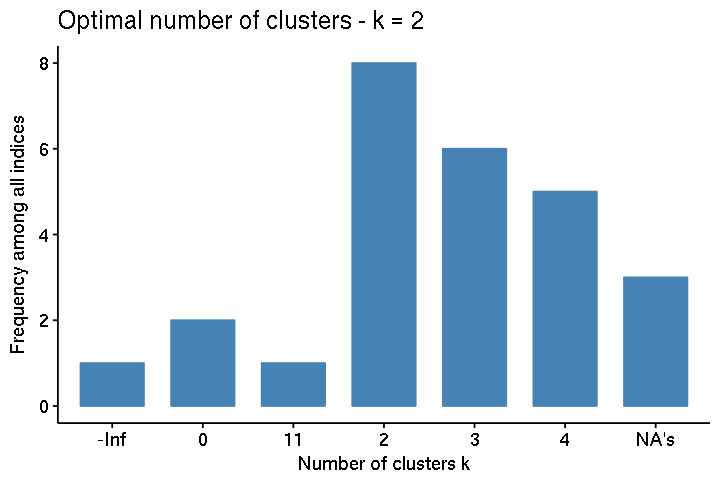

In [58]:
options(repr.plot.width=6, repr.plot.height=4)
fviz_nbclust(nb)

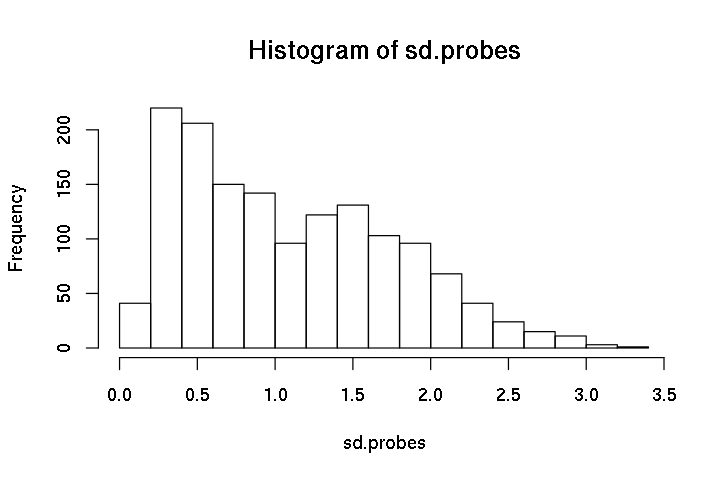

In [35]:
options(repr.plot.width=6, repr.plot.height=4)
sd.probes <- apply(HM27.processed[probe.idx,], 1, sd)
hist(sd.probes)

In [55]:
sum(sd.probes > 0.5)

[1] 1102

### Cut the tree using the optimal number of cluster

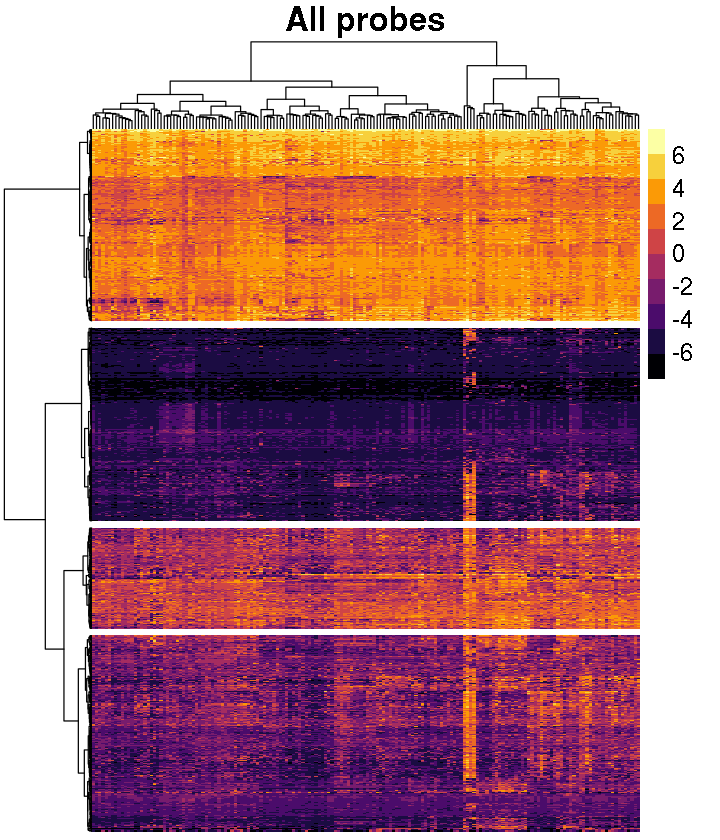

In [67]:
options(repr.plot.width=6, repr.plot.height=7)

res <- pheatmap(
  mat               = HM27.processed[probe.idx,][sd.probes > 0.5,],
  color             = inferno(10),
  border_color      = NA,
  show_colnames     = FALSE,
  show_rownames     = FALSE,
  clustering_method = "ward.D2",
  fontsize          = 14,
  cutree_rows       = 4,
  main              = "All probes"
)

In [68]:
res.clust <- cbind(HM27.processed[probe.idx,][sd.probes > 0.5,], 
                   cluster = cutree(res$tree_row, k = 4))
head(res.clust)

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03,cluster
PHF13,0.3423768,3.8991099,-0.3258948,2.1324051,0.6044729,4.276452,0.09398224,1.6023812,-2.457818,-1.0911698,⋯,-0.2017327,2.9498283,-4.423115,0.7053693,1.8447694,2.1503474,-4.591566,4.080576,1.0069733,1
THEM4,-6.3682729,-4.3682783,2.4186535,-1.1480269,-3.6899751,-4.178010,-6.13787492,-2.6065913,-5.844866,-1.9273946,⋯,-5.9987964,-1.9099158,-6.357597,-6.1512105,-5.4294179,-5.8906942,2.651787,-4.851152,-6.2149849,2
THEM4,-5.2171690,-4.2409137,2.5841896,-3.5538918,-4.6451805,-4.960789,-4.37749236,-3.6162094,-4.026943,-3.6255177,⋯,-4.2415622,-2.3425718,-5.486683,-4.2190998,-4.6114323,-5.1899602,2.841078,-3.840631,-4.1910258,2
FCRLB,-0.9782818,2.5908073,1.5873586,2.7600751,0.4951331,2.548310,-0.97602678,0.3811104,2.164420,2.6386810,⋯,1.7295453,2.7149624,1.949443,0.5670211,1.9374083,2.7579543,1.630285,2.757094,0.3675231,3
FCRLB,3.9935180,-0.1126377,3.1451606,1.8200750,1.6615166,3.118322,2.82423923,0.8077440,1.875374,2.0405827,⋯,1.1634553,0.1970957,1.590352,1.8592897,2.1602422,2.4127415,3.545203,2.690430,1.5717340,3
DNM3,-0.5110940,0.9897193,-1.1514153,-0.3820692,-0.6005072,1.554936,-0.46623189,1.4261528,-1.212581,-0.9601648,⋯,-0.9569933,0.4465626,-2.241730,0.7956812,-0.5655719,0.2543318,2.428098,1.742139,-0.7502622,1


In [70]:
write.table(res.clust, file='../data/LAML/processed/Figueroa-HM27-imputed-M.4cluster.tsv', sep='\t', quote=F, row.names=T, col.names=T)

## RNAseq probes find those related to the transcription and methylation

In [2]:
rnaseq.raw <- read.csv('../data/LAML/processed/rnaseq-imputed-matched.tsv', sep='\t', stringsAsFactor=F, header=F)

In [4]:
rnaseq.filtered <- data.matrix(rnaseq.raw[-1,-1])
colnames(rnaseq.filtered) <- rnaseq.raw[1,-dim(rnaseq.raw)[2]]
rownames(rnaseq.filtered) <- rnaseq.raw[-1,1]

In [5]:
genes <- unique(rownames(rnaseq.filtered))[-1]
tail(genes)

[1] "ZYG11B"    "ZYX"       "ZZEF1"     "ZZZ3"      "psiTPTE22" "tAKR"

In [31]:
annotations <- queryMany(genes, scopes='symbol', fields=c('go'), species='human',
                 returnall=T)

Querying chunk 1
Querying chunk 2
Querying chunk 3
Querying chunk 4
Querying chunk 5
Querying chunk 6
Querying chunk 7
Querying chunk 8
Querying chunk 9
Querying chunk 10
Querying chunk 11
Querying chunk 12
Querying chunk 13
Querying chunk 14
Querying chunk 15
Querying chunk 16
Querying chunk 17


Finished


In [32]:
terms <- c() # get biological process terms
for (i in seq(length(annotations$response$query))) {
  if (is.na(annotations$response$notfound[i])) {
    query <- annotations$response$query[i]
    termConcat <- paste(as.character(annotations$response$go.BP[[i]]$term), collapse=', ')
    terms <- rbind(terms, c(query, termConcat))
  }
}

In [33]:
terms.cleaned <- data.frame(name=terms[,1], annotation=terms[,2]) %>%
  dplyr::group_by(name) %>%
  dplyr::mutate(annotations = paste0(annotation, collapse = ", ")) %>%
  dplyr::select(-annotation) %>%
  dplyr::distinct()
terms.filtered <- terms.cleaned %>%
  dplyr::filter(grepl('methyl|transcrip', annotations)) # 3304 left

In [35]:
head(terms.filtered)

name,annotations


In [36]:
dim(terms.filtered)

[1] 3304    2

In [39]:
filtered.idx <- which(rownames(rnaseq.filtered) %in% terms.filtered$name)

In [41]:
rnaseq.filtered2 <- rnaseq.filtered[filtered.idx,]

In [42]:
write.table(rnaseq.filtered2, file='../data/LAML/processed/rnaseq-imputed-matched-filtered.tsv', sep='\t', quote=F, row.names=T, col.names=T)